## Metodología

### Preparación de los datos

In [96]:
import os
import re
from tqdm import tqdm
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [31]:
# Directorio donde se encuentran las imágenes
IMAGE_PATH = "data/UTKFACE"

# Regex para capturar las etiquetas de género en el nombre del archivo
# [age]_[gender]_[race]_[date&time].jpg.chip.jpg
FILENAME_PATTERN = re.compile(r"\d+_([01])_[0-4]_\d+.jpg.chip.jpg")

In [32]:
data = []
invalid_file_paths = []

# Filtrar imágenes con etiquetas válidas
try:
    all_files = glob(f"{IMAGE_PATH}/*.jpg")
    if not all_files:
        raise FileNotFoundError(
            f"No se encontraron archivos en el directorio {IMAGE_PATH}"
        )

    for file_path in tqdm(all_files, desc="Filtrando imágenes"):
        filename = os.path.basename(file_path)
        match = FILENAME_PATTERN.match(filename)

        if match:
            [gender] = match.groups()
            data.append(
                {
                    "file_path": filename,
                    "gender": int(gender),
                }
            )
        else:
            invalid_file_paths.append(filename)

    df = pd.DataFrame(data)
    # Eliminar variables temporales para liberar memoria
    del data, all_files

    print("\n¡Filtrado completado con éxito!")

except FileNotFoundError as e:
    print(f"\nError de ruta: {e}")
    df = pd.DataFrame()
except Exception as e:
    print(f"\nError inesperado: {e}")
    df = pd.DataFrame()

if invalid_file_paths:
    print(f"\nImágenes con etiqueta inválida: {len(invalid_file_paths)}")
    for file in invalid_file_paths:
        print(f"- {file}")
else:
    print("\nSe filtraron todas las imágenes correctamente.")

Filtrando imágenes: 100%|██████████| 23708/23708 [00:00<00:00, 228914.87it/s]


¡Filtrado completado con éxito!

Imágenes con etiqueta inválida: 4
- 24_0_1_20170116220224657 .jpg.chip.jpg
- 39_1_20170116174525125.jpg.chip.jpg
- 61_1_20170109142408075.jpg.chip.jpg
- 61_1_20170109150557335.jpg.chip.jpg


In [33]:
# Dimensión objetivo en píxeles
TARGET_SIZE = (32, 32)


def preprocess_image(filename: str, images_path: str) -> np.ndarray:
    """
    Preprocesa una imagen: redimensiona, convierte a escala de grises y normaliza.

    Args:
        filename: Nombre del archivo de la imagen.
        images_path: Ruta del directorio que contiene las imágenes.

    Returns:
        Vector numpy con la imagen preprocesada.
    """
    file_path = os.path.join(images_path, filename)

    try:
        img = cv2.imread(file_path)

        if img is None:
            raise ValueError(f"Error al cargar la imagen: {file_path}")

        # Redimensionar a tamaño objetivo
        img = cv2.resize(img, TARGET_SIZE)
        # Convertir a escala de grises
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Normalizar a rango [0, 1]
        img = img / 255.0

        # Aplanar la imagen en un vector
        vector = img.flatten()

        return vector

    except ValueError as e:
        print(e)
        return None
    except Exception as e:
        print(f"Error inesperado al procesar la imagen: {e}")
        return None

In [34]:
image_vectors = []
valid_indices = []
invalid_images = []

# Preprocesar imágenes y almacenar vectores válidos
for index, row in tqdm(df.iterrows(), total=len(df), desc="Preprocesando imágenes"):
    vector = preprocess_image(row["file_path"], IMAGE_PATH)

    if vector is not None:
        image_vectors.append(vector)
        valid_indices.append(index)
    else:
        invalid_images.append(row["file_path"])

print(f"\n¡Preprocesamiento completado!")

if invalid_images:
    print(f"\nImágenes no procesadas: {len(invalid_images)}")
    for img in invalid_images:
        print(f"- {img}")
else:
    print("\nSe procesaron todas las imágenes correctamente.")

Preprocesando imágenes: 100%|██████████| 23704/23704 [00:14<00:00, 1633.15it/s]


¡Preprocesamiento completado!

Se procesaron todas las imágenes correctamente.


In [35]:
# Crear matriz de datos X y vector de etiquetas y
X = np.array(image_vectors)

df = df.loc[valid_indices].reset_index(drop=True)
y = df["gender"].values

print("¡Datos preparados!")
print(f"\nDimensión de la matriz de datos X: {X.shape}")
print(f"Dimensión del vector de etiquetas y: {y.shape}")

del df, image_vectors, valid_indices

¡Datos preparados!

Dimensión de la matriz de datos X: (23704, 1024)
Dimensión del vector de etiquetas y: (23704,)


### División del conjunto de datos

In [36]:
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

RANDOM_SEED = 42

In [37]:
# Separar el conjunto de prueba del resto de los datos
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Separar el conjunto de validación del conjunto de entrenamiento
VALIDATION_SIZE_ADJUSTED = VALIDATION_SIZE / (1 - TEST_SIZE)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=VALIDATION_SIZE_ADJUSTED,
    random_state=RANDOM_SEED,
    stratify=y_temp,
)

print("¡División de datos completada!")
print(f"\nDimensiones de los conjuntos:")
print(
    f"- Entrenamiento ({round((1 - TEST_SIZE - VALIDATION_SIZE)*100)}%): X_train: {X_train.shape}, y_train: {y_train.shape}"
)
print(
    f"- Validación ({round(VALIDATION_SIZE*100)}%): X_val: {X_val.shape}, y_val: {y_val.shape}"
)
print(
    f"- Prueba ({round(TEST_SIZE*100)}%): X_test: {X_test.shape}, y_test: {y_test.shape}"
)

print()

del X, y, X_temp, y_temp

¡División de datos completada!

Dimensiones de los conjuntos:
- Entrenamiento (60%): X_train: (14222, 1024), y_train: (14222,)
- Validación (20%): X_val: (4741, 1024), y_val: (4741,)
- Prueba (20%): X_test: (4741, 1024), y_test: (4741,)



### Análisis mediante PCA

In [38]:
# Estandarizar los datos
scaler = StandardScaler()

Z_train = scaler.fit_transform(X_train)
Z_val = scaler.transform(X_val)
Z_test = scaler.transform(X_test)

del X_train, X_val, X_test

In [39]:
# Ajustar PCA sobre el conjunto de entrenamiento
# n_components=None para conservar toda la varianza
pca = PCA(n_components=None)
pca.fit(Z_train)

# Calcular la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
# Calcular la varianza explicada acumulada
cumulative_variance = np.cumsum(explained_variance)

print("Análisis de PCA:")
print(f"\nNúmero de componentes calculados: {len(explained_variance)}")
print("Varianza explicada por los primeros 5 componentes:")
for i in range(5):
    print(f"- [{i+1}]: {explained_variance[i]*100:.2f}%")

Análisis de PCA:

Número de componentes calculados: 1024
Varianza explicada por los primeros 5 componentes:
- [1]: 31.07%
- [2]: 12.10%
- [3]: 11.67%
- [4]: 4.20%
- [5]: 2.83%


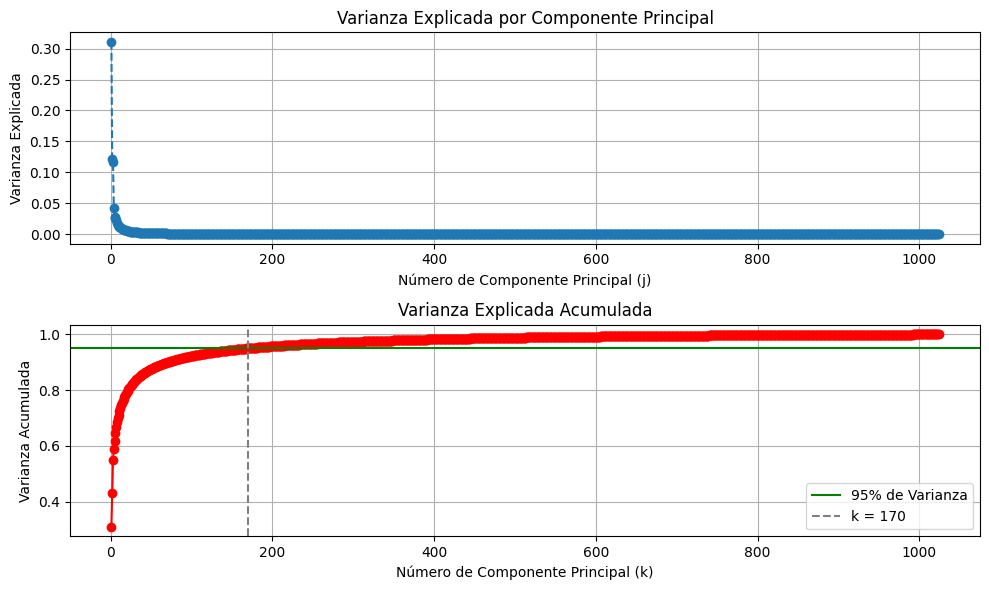

In [40]:
plt.figure(figsize=(10, 6))

# Gráfico de varianza explicada por componente
plt.subplot(2, 1, 1)
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Varianza Explicada por Componente Principal")
plt.xlabel("Número de Componente Principal (j)")
plt.ylabel("Varianza Explicada")
plt.grid(True)

# Gráfico de varianza explicada acumulada
plt.subplot(2, 1, 2)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="-",
    color="red",
)
plt.title("Varianza Explicada Acumulada")
plt.xlabel("Número de Componente Principal (k)")
plt.ylabel("Varianza Acumulada")

# Identificar punto donde se alcanza el 95% de varianza explicada
V_TARGET = 0.95
k_95 = np.argmax(cumulative_variance >= V_TARGET) + 1

# Dibujar líneas para identificar el 95% y el k óptimo
plt.axhline(
    y=V_TARGET, color="green", linestyle="-", label=f"{V_TARGET*100:.0f}% de Varianza"
)
plt.axvline(x=k_95, color="gray", linestyle="--", label=f"k = {k_95}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Reajustar PCA con el número óptimo de componentes
pca = PCA(n_components=k_95, random_state=RANDOM_SEED)

# Proyectar los datos en el nuevo espacio PCA
Z_train = pca.fit_transform(Z_train)
Z_val = pca.transform(Z_val)
Z_test = pca.transform(Z_test)

print("¡Transformación PCA completada!")

print("\nMatriz de entrenamiento tras PCA (Z_train):", Z_train.shape)
print("Matriz de validación tras PCA (Z_val):", Z_val.shape)
print("Matriz de prueba tras PCA (Z_test):", Z_test.shape)

¡Transformación PCA completada!

Matriz de entrenamiento tras PCA (Z_train): (14222, 170)
Matriz de validación tras PCA (Z_val): (4741, 170)
Matriz de prueba tras PCA (Z_test): (4741, 170)


### Cálculo de LDA y representación unidimensional

In [42]:
# Ajustar LDA sobre el conjunto de entrenamiento Z_train
lda = LDA(n_components=1)
lda.fit(Z_train, y_train)

# Obtener el vector de proyección LDA
w_lda = lda.scalings_

print("¡Ajuste de LDA completado!")
print("\nVector de proyección LDA (w_lda):", w_lda.shape)

¡Ajuste de LDA completado!

Vector de proyección LDA (w_lda): (170, 1)


In [43]:
# Proyectar los datos en el espacio LDA
X_train_lda = lda.transform(Z_train).flatten()
X_val_lda = lda.transform(Z_val).flatten()
X_test_lda = lda.transform(Z_test).flatten()

del Z_train, Z_val, Z_test

print("¡Transformación LDA completada!")

print("\nDatos de entrenamiento tras LDA (X_train_lda):", X_train_lda.shape)
print("Datos de validación tras LDA (X_val_lda):", X_val_lda.shape)
print("Datos de prueba tras LDA (X_test_lda):", X_test_lda.shape)

¡Transformación LDA completada!

Datos de entrenamiento tras LDA (X_train_lda): (14222,)
Datos de validación tras LDA (X_val_lda): (4741,)
Datos de prueba tras LDA (X_test_lda): (4741,)


### Distribuciones p(X | Male) y p(X | Female)

In [44]:
# Subconjuntos de datos de entreo para cada clase
X_male = X_train_lda[y_train == 0]
X_female = X_train_lda[y_train == 1]

# Estimar parámetros de la distribución normal para cada clase
mu_male = np.mean(X_male)
sigma2_male = np.var(X_male)

mu_female = np.mean(X_female)
sigma2_female = np.var(X_female)

print("Paramétros estimados de la distribución normal:")

print(f"\nClase Masculino (0): μ = {mu_male:.4f}, σ² = {sigma2_male:.4f}")
print(f"Clase Femenino (1): μ = {mu_female:.4f}, σ² = {sigma2_female:.4f}")

Paramétros estimados de la distribución normal:

Clase Masculino (0): μ = -0.9477, σ² = 1.0041
Clase Femenino (1): μ = 1.0379, σ² = 0.9952


In [45]:
def gaussian_pdf(x: np.ndarray, mu: float, sigma2: float) -> np.ndarray:
    """
    Calcula la función de densidad de probabilidad (PDF) de una distribución normal.

    Args:
        x: Datos de entrada.
        mu: Media de la distribución.
        sigma2: Varianza de la distribución.

    Returns:
        Valores de la PDF evaluados en x.
    """
    coeff = 1 / np.sqrt(2 * np.pi * sigma2)
    exponent = -((x - mu) ** 2) / (2 * sigma2)
    return coeff * np.exp(exponent)

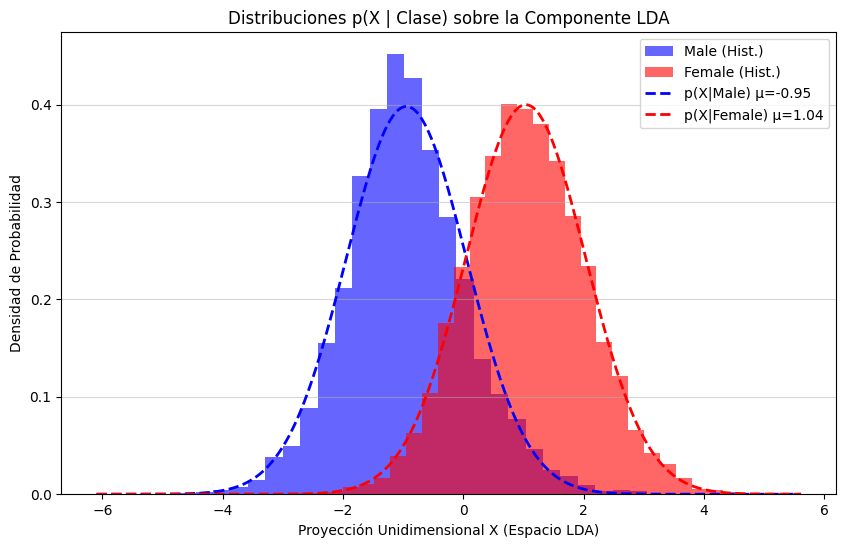

In [46]:
# Crear un rango de valores para graficar las distribuciones
x_range = np.linspace(min(X_train_lda) - 0.5, max(X_train_lda) + 0.5, 500)

# Calcular las PDFs para cada clase
pdf_male = gaussian_pdf(x_range, mu_male, sigma2_male)
pdf_female = gaussian_pdf(x_range, mu_female, sigma2_female)

plt.figure(figsize=(10, 6))

# Histogramas normalizados (density=True)
plt.hist(X_male, bins=30, density=True, alpha=0.6, label="Male (Hist.)", color="blue")
plt.hist(
    X_female, bins=30, density=True, alpha=0.6, label="Female (Hist.)", color="red"
)

# Curvas de las densidades Gaussianas estimadas
plt.plot(x_range, pdf_male, "b--", linewidth=2, label=f"p(X|Male) μ={mu_male:.2f}")
plt.plot(
    x_range, pdf_female, "r--", linewidth=2, label=f"p(X|Female) μ={mu_female:.2f}"
)

plt.title("Distribuciones p(X | Clase) sobre la Componente LDA")
plt.xlabel("Proyección Unidimensional X (Espacio LDA)")
plt.ylabel("Densidad de Probabilidad")
plt.legend()
plt.grid(axis="y", alpha=0.5)
plt.show()

### Naive Bayes en el espacio LDA

In [47]:
# Calcular probabilidades a priori
N_train = len(y_train)
N_male = np.sum(y_train == 0)
N_female = np.sum(y_train == 1)

p_male = N_male / N_train
p_female = N_female / N_train

print("Probabilidades a priori:")
print(f"\np(Male): {p_male:.4f}")
print(f"p(Female): {p_female:.4f}")

Probabilidades a priori:

p(Male): 0.5227
p(Female): 0.4773


In [ ]:
def posterior_probability(X: np.ndarray) -> np.ndarray:
    """
    Calcula la probabilidad a posteriori para las clases Male y Female para un
    conjunto de datos X.

    Args:
        X: Datos de entrada en el espacio LDA.

    Returns:
        2-tupla con las probabilidades a posteriori para cada clase.
    """
    # Calcular las PDFs para cada clase
    p_x_given_male = gaussian_pdf(X, mu_male, sigma2_male)
    p_x_given_female = gaussian_pdf(X, mu_female, sigma2_female)

    # Calular la probabilidad total p(x)
    p_x = (p_x_given_male * p_male) + (p_x_given_female * p_female)

    # Evitar división por cero
    p_x[p_x == 0] = 1e-10

    # Calcular las probabilidades a posteriori
    p_male_given_x = (p_x_given_male * p_male) / p_x
    p_female_given_x = (p_x_given_female * p_female) / p_x

    return p_male_given_x, p_female_given_x

In [52]:
# Calcular probabilidades a posteriori para cada conjunto
p_male_train, p_female_train = posterior_probability(X_train_lda)
p_male_test, p_female_test = posterior_probability(X_test_lda)
p_male_val, p_female_val = posterior_probability(X_val_lda)

print("Cálculo de probabilidades a posteriori completado.")
print(f"\nPrimeras 5 probabilidades a posteriori en el conjunto de entrenamiento:")
print(f"Male: {p_male_train[:5].round(4)}")
print(f"Female: {p_female_train[:5].round(4)}")

Cálculo de probabilidades a posteriori completado.

Primeras 5 probabilidades a posteriori en el conjunto de entrenamiento:
Male: [0.9624 0.972  0.9862 0.5251 0.9643]
Female: [0.0376 0.028  0.0138 0.4749 0.0357]


In [108]:
# Implementar regla de decisión Bayesiana
y_pred_nb_test = (p_female_test > 0.5).astype(int)

print("--- Predicciones Naive Bayes ---\n")

print(f"Etiquetas reales y_test: {y_test[:10]}")
print(f"Etiquetas predichas y_pred_nb_test: {y_pred_nb_test[:10]}")

--- Predicciones Naive Bayes ---

Etiquetas reales y_test: [0 0 0 1 1 0 1 1 1 0]
Etiquetas predichas y_pred_nb_test: [1 0 0 1 1 1 1 1 1 0]


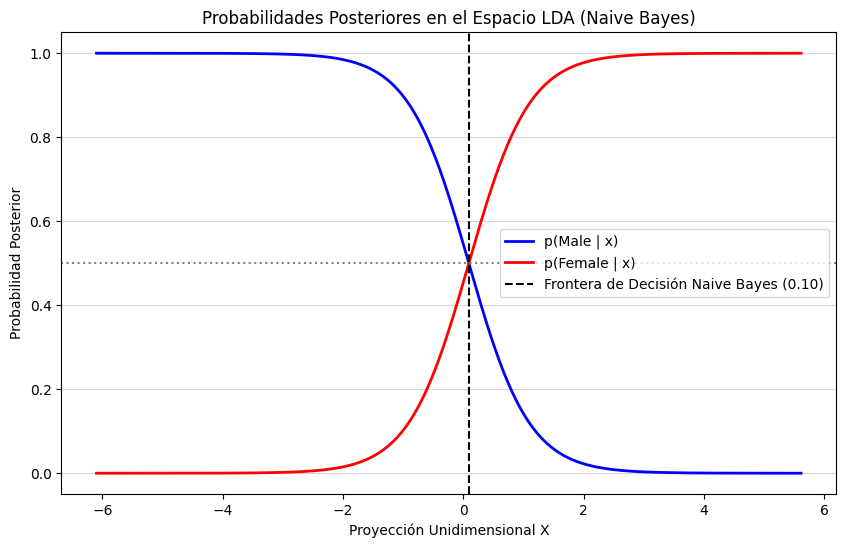

In [109]:
p_male_range, p_female_range = posterior_probability(x_range)

plt.figure(figsize=(10, 6))

plt.plot(x_range, p_male_range, "b-", linewidth=2, label="p(Male | x)")
plt.plot(x_range, p_female_range, "r-", linewidth=2, label="p(Female | x)")

# La frontera de decisión está donde p(Male|x) = p(Female|x) = 0.5
nb_boundary = x_range[np.argmin(np.abs(p_male_range - 0.5))]
plt.axvline(
    x=nb_boundary,
    color="k",
    linestyle="--",
    label=f"Frontera de Decisión Naive Bayes ({nb_boundary:.2f})",
)
plt.axhline(y=0.5, color="gray", linestyle=":")

plt.title("Probabilidades Posteriores en el Espacio LDA (Naive Bayes)")
plt.xlabel("Proyección Unidimensional X")
plt.ylabel("Probabilidad Posterior")
plt.legend()
plt.grid(axis="y", alpha=0.5)
plt.show()

### Regresión Logística en el espacio LDA

In [ ]:
# Reajustar las matrices para que tengan forma (n_samples, 1) explícita
X_train_reshaped = X_train_lda.reshape(-1, 1)
X_val_reshaped = X_val_lda.reshape(-1, 1)
X_test_reshaped = X_test_lda.reshape(-1, 1)

# Entrenar y evaluar modelos de regresión logística con diferentes valores de C
C_values = [0.01, 0.1, 1, 10, 100]
best_accuracy = 0
best_C = None
best_model_logreg = None

print("--- Ajuste de hiperparámetros de Regresión Logística ---\n")
print("| Valor C | Accuracy (Validación) |")
print("-" * 35)

for C in C_values:
    # Entrenar el modelo de regresión logística
    logreg = LogisticRegression(C=C, random_state=RANDOM_SEED)
    logreg.fit(X_train_reshaped, y_train)

    # Evaluar en el conjunto de validación
    y_val_pred = logreg.predict(X_val_reshaped)
    accuracy = accuracy_score(y_val, y_val_pred)

    print(f"| {C:^8}| {accuracy:^21.4f} |")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C
        best_model_logreg = logreg

print(f"\nMejor valor de C: {best_C} con Accuracy: {best_accuracy*100:.4f}%")

--- Ajuste de hiperparámetros de Regresión Logística ---

| Valor C | Accuracy (Validación) |
-----------------------------------
|   0.01  |        0.8435         |
|   0.1   |        0.8433         |
|    1    |        0.8433         |
|    10   |        0.8433         |
|   100   |        0.8433         |

Mejor valor de C: 0.01 con Accuracy: 84.3493%


In [ ]:
# Obtener predicciones en el conjunto de prueba con el mejor modelo
y_test_pred_logreg = best_model_logreg.predict(X_test_reshaped)

# Calcular accuracy en el conjunto de prueba
test_accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)

print("--- Resultados en el conjunto de prueba ---")
print(
    f"\nAccuracy en el conjunto de prueba con Regresión Logística (C={best_C}): {test_accuracy_logreg*100:.4f}%"
)

--- Resultados en el conjunto de prueba ---

Accuracy en el conjunto de prueba con Regresión Logística (C=0.01): 83.7587%


### SVM en el espacio LDA

In [ ]:
# Lista de valores de C a probar
C_values_svm = [0.001, 0.1, 1, 10, 100]
best_accuracy_linear = 0
best_C_linear = None
best_model_svm_linear = None

accuracy_scores_linear = []

for C in tqdm(C_values_svm, desc="Ajuste de SVM Lineal"):
    # Entrenar el modelo SVM lineal
    svm_linear = SVC(C=C, kernel="linear", random_state=RANDOM_SEED)
    svm_linear.fit(X_train_reshaped, y_train)

    y_val_pred = svm_linear.predict(X_val_reshaped)
    accuracy = accuracy_score(y_val, y_val_pred)

    accuracy_scores_linear.append(accuracy)

    if accuracy > best_accuracy_linear:
        best_accuracy_linear = accuracy
        best_C_linear = C
        best_model_svm_linear = svm_linear

print("\n--- Ajuste de hiperparámetros de SVM Lineal ---\n")
print("| Valor C | Accuracy (Validación) |")
print("-" * 35)
for C, acc in zip(C_values_svm, accuracy_scores_linear):
    print(f"| {C:^8}| {acc:^21.4f} |")

print(
    f"\nMejor valor de C para SVM Lineal: {best_C_linear} con Accuracy: {best_accuracy_linear*100:.4f}%"
)

Ajuste de SVM Lineal: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


--- Ajuste de hiperparámetros de SVM Lineal ---

| Valor C | Accuracy (Validación) |
-----------------------------------
|  0.001  |        0.8422         |
|   0.1   |        0.8410         |
|    1    |        0.8410         |
|    10   |        0.8410         |
|   100   |        0.8410         |

Mejor valor de C para SVM Lineal: 0.001 con Accuracy: 84.2227%


In [ ]:
# Obtener predicciones en el conjunto de prueba con el mejor modelo
y_test_pred_svm_linear = best_model_svm_linear.predict(X_test_reshaped)

# Calcular accuracy en el conjunto de prueba
test_accuracy_svm_linear = accuracy_score(y_test, y_test_pred_svm_linear)

print("--- Resultados en el conjunto de prueba ---")
print(
    f"\nAccuracy en el conjunto de prueba con SVM Lineal (C={best_C_linear}): {test_accuracy_svm_linear*100:.4f}%"
)

--- Resultados en el conjunto de prueba ---

Accuracy en el conjunto de prueba con SVM Lineal (C=0.001): 83.8853%


In [ ]:
# Lista de valores de gamme a probar
gamma_value = [0.001, 0.1, 1]
best_accuracy_rbf = 0
best_C_rbf = None
best_gamma_rbf = None
best_model_svm_rbf = None

accuracy_scores_rbf = []

for C in tqdm(C_values_svm, desc="Ajuste de SVM RBF"):
    for gamma in gamma_value:
        # Entrenar el modelo SVM lineal
        svm_rbf = SVC(C=C, kernel="rbf", gamma=gamma, random_state=RANDOM_SEED)
        svm_rbf.fit(X_train_reshaped, y_train)

        y_val_pred = svm_rbf.predict(X_val_reshaped)
        accuracy = accuracy_score(y_val, y_val_pred)

        accuracy_scores_rbf.append((accuracy, C, gamma))

        if accuracy > best_accuracy_rbf:
            best_accuracy_rbf = accuracy
            best_C_rbf = C
            best_gamma_rbf = gamma
            best_model_svm_rbf = svm_rbf

print("\n--- Ajuste de hiperparámetros de SVM RBF ---\n")
print("| Valor C | Gamma | Accuracy (Validación) |")
print("-" * 43)
for acc, C, gamma in accuracy_scores_rbf:
    print(f"| {C:^8}| {gamma:^6} | {acc:^21.4f} |")

print(
    f"\nMejor RBF: C={best_C_rbf}, Gamma={best_gamma_rbf}, Accuracy: {best_accuracy_rbf*100:.4f}%"
)

Ajuste de SVM RBF: 100%|██████████| 5/5 [02:01<00:00, 24.25s/it]


--- Ajuste de hiperparámetros de SVM RBF ---

| Valor C | Gamma | Accuracy (Validación) |
-------------------------------------------
|  0.001  | 0.001  |        0.5227         |
|  0.001  |  0.1   |        0.8433         |
|  0.001  |   1    |        0.8414         |
|   0.1   | 0.001  |        0.8426         |
|   0.1   |  0.1   |        0.8448         |
|   0.1   |   1    |        0.8435         |
|    1    | 0.001  |        0.8412         |
|    1    |  0.1   |        0.8448         |
|    1    |   1    |        0.8435         |
|    10   | 0.001  |        0.8418         |
|    10   |  0.1   |        0.8437         |
|    10   |   1    |        0.8435         |
|   100   | 0.001  |        0.8414         |
|   100   |  0.1   |        0.8441         |
|   100   |   1    |        0.8426         |

Mejor RBF: C=0.1, Gamma=0.1, Accuracy: 84.4758%


In [ ]:
# Obtener predicciones en el conjunto de prueba con el mejor modelo
y_test_pred_svm_rbf = best_model_svm_rbf.predict(X_test_reshaped)

# Calcular accuracy en el conjunto de prueba
test_accuracy_svm_rbf = accuracy_score(y_test, y_test_pred_svm_rbf)

print("--- Resultados en el conjunto de prueba ---")
print(
    f"\nAccuracy en el conjunto de prueba con SVM RBF (C={best_C_rbf}, Gamma={best_gamma_rbf}): {test_accuracy_svm_rbf*100:.4f}%"
)

--- Resultados en el conjunto de prueba ---

Accuracy en el conjunto de prueba con SVM RBF (C=0.1, Gamma=0.1): 83.8009%


In [84]:
# Coeficientes del modelo SVM lineal
w_svm = best_model_svm_linear.coef_[0][0]
b_svm = best_model_svm_linear.intercept_[0]

# Calcular la frontera de decisión
svm_boundary = -b_svm / w_svm

# Obtener los índices de los Vectores de Soporte (Support Vectors)
sv_indices = best_model_svm_linear.support_

# Obtener los valores de X_train_lda de los Vectores de Soporte
X_sv = X_train_lda[sv_indices]
y_sv = y_train[sv_indices]

## Evaluación y Métricas

In [87]:
# Definimos la clase POSITIVA como Male (0) para la Matriz de Confusión y Precision/Recall.
POS_LABEL = 0


def report_metrics(
    y_real: np.ndarray, y_pred: np.ndarray, model_name: str, pos_label: int = POS_LABEL
):
    """
    Calcula y devuelve las métricas de evaluación para un modelo de clasificación.

    Args:
        y_real: Etiquetas reales.
        y_pred: Etiquetas predichas.
        model_name: Nombre del modelo para el reporte.
        pos_label: Etiqueta de la clase positiva.

    Returns:
        Diccionario con las métricas calculadas.
    """
    # Matriz de confusión
    cm = confusion_matrix(y_real, y_pred, labels=[pos_label, 1 - pos_label])

    # Accuracy
    accuracy = accuracy_score(y_real, y_pred)

    # Precision
    precision = precision_score(y_real, y_pred, pos_label=pos_label)

    # Recall
    recall = recall_score(y_real, y_pred, pos_label=pos_label)

    # F1-Score
    f1 = f1_score(y_real, y_pred, pos_label=pos_label)

    return {
        "model": model_name,
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

In [110]:
# Calcular métricas para los modelos
metrics_nb = report_metrics(y_test, y_pred_nb_test, "Naive Bayes")
metrics_logreg = report_metrics(y_test, y_test_pred_logreg, "Regresión Logística")
metrics_svm_linear = report_metrics(y_test, y_test_pred_svm_linear, "SVM Lineal")

results = [metrics_nb, metrics_logreg, metrics_svm_linear]

print("--- Métricas de Evaluación de Modelos ---\n")
header = "| Accuracy | Precision | Recall | F1-Score |"
print(f"{header}\n{'-' * len(header)}")
for res in results:
    print(
        f"| {res['accuracy']:^9.4f}| {res['precision']:^10.4f}| {res['recall']:^7.4f}| {res['f1_score']:^9.4f}|  ({res['model']})"
    )

--- Métricas de Evaluación de Modelos ---

| Accuracy | Precision | Recall | F1-Score |
--------------------------------------------
|  0.8378  |   0.8406  | 0.8511 |  0.8458  |  (Naive Bayes)
|  0.8376  |   0.8419  | 0.8487 |  0.8453  |  (Regresión Logística)
|  0.8389  |   0.8456  | 0.8462 |  0.8459  |  (SVM Lineal)


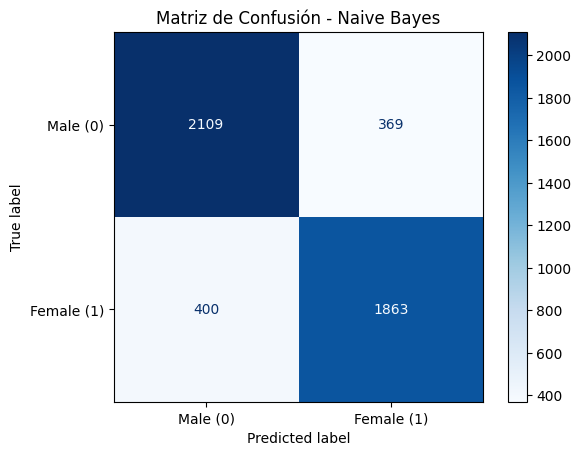

In [111]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=metrics_nb["confusion_matrix"],
    display_labels=class_names,
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()

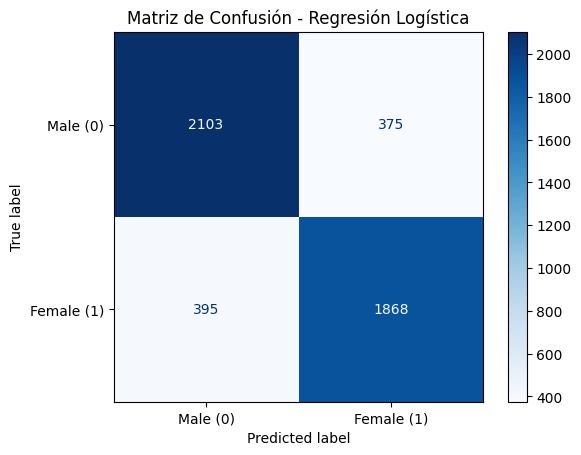

In [ ]:
class_names = ["Male (0)", "Female (1)"]

disp = ConfusionMatrixDisplay(
    confusion_matrix=metrics_logreg["confusion_matrix"],
    display_labels=class_names,
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

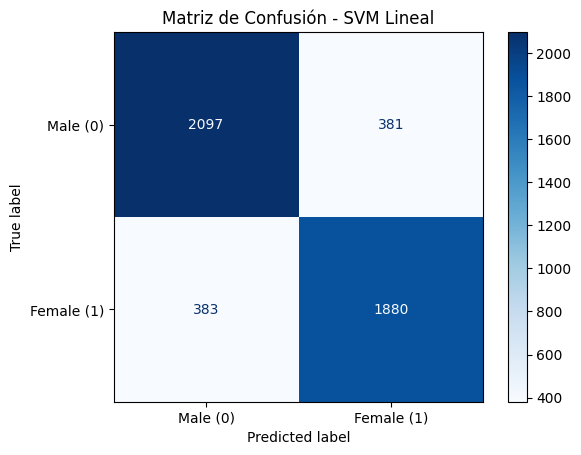

In [107]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=metrics_svm_linear["confusion_matrix"],
    display_labels=class_names,
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - SVM Lineal")
plt.show()